# Batch Document Extraction with Llama Vision (V2)

Streamlined batch processing notebook using modular components.

**V2 Features:**
- **Sophisticated bank statement extraction** using multi-turn UnifiedBankExtractor
- Turn 0: Header detection (identifies actual column names)
- Turn 1: Adaptive extraction with structure-dynamic prompts
- Automatic strategy selection: BALANCE_DESCRIPTION, AMOUNT_DESCRIPTION, etc.
- Early model loading
- Configurable output directory
- Comprehensive analytics and visualizations
- Clean, modular code structure

**Bank Statement Processing Toggle:**
- `USE_SOPHISTICATED_BANK_EXTRACTION`: True (default) uses multi-turn extraction
- `ENABLE_BALANCE_CORRECTION`: Optional mathematical balance validation

## 1. Imports

In [ ]:
#Cell 1
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'

# Standard library imports
import warnings
from datetime import datetime
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
from IPython.display import display, Image
from rich import print as rprint
from rich.console import Console

# Project-specific imports
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from common.llama_model_loader_robust import load_llama_model_robust

# V2: Sophisticated bank statement processing
from common.bank_statement_adapter import BankStatementAdapter

print("✅ All imports loaded successfully")
print("✅ Llama batch processing modules imported successfully")
print("✅ V2: BankStatementAdapter imported for sophisticated bank extraction")
warnings.filterwarnings('ignore')

## 2. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [2]:
#Cell 2
# Initialize console for rich output
console = Console()# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 3. Configuration

In [ ]:
#Cell 3
# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    # 'MODEL_PATH': "/efs/shared/PTM/Llama-3.2-11B-Vision-Instruct",
    'MODEL_PATH': "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct",

    # Batch settings - Using base path for consistency
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    # 'OUTPUT_BASE': f'{base_data_path}/output',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': True,  # Enable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)

    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,

    # L40S optimization settings
    'USE_QUANTIZATION': False,
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,  # Reduced for L40S (was 4000 for V100)
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True,
    
    # ============================================================================
    # V2: SOPHISTICATED BANK STATEMENT EXTRACTION
    # ============================================================================
    # Use multi-turn UnifiedBankExtractor for bank statements instead of
    # single-turn extraction. This provides:
    # - Turn 0: Header detection (identifies actual column names)
    # - Turn 1: Adaptive extraction with structure-dynamic prompts
    # - Automatic strategy selection based on detected columns
    # - Higher accuracy for bank statements (~85%+ vs ~72%)
    #
    # Set to False to use original single-turn extraction behavior
    # ============================================================================
    'USE_SOPHISTICATED_BANK_EXTRACTION': True,
    
    # Optional: Enable balance-based mathematical correction
    # Uses balance column deltas to validate debit/credit values
    'ENABLE_BALANCE_CORRECTION': False,
    
    # ============================================================================
    # IMAGE PREPROCESSING SETTINGS
    # ============================================================================
    # Control optional image preprocessing before model inference
    # 
    # ENABLE_PREPROCESSING: Master switch to enable/disable preprocessing
    # PREPROCESSING_MODE: Select preprocessing intensity
    #   - 'light' or 'recommended': Gentle enhancement for high-quality scans
    #     (upscale if <1500px, moderate sharpening, slight contrast boost)
    #   - 'moderate': Stronger enhancement for low-resolution scans
    #     (upscale to 2000px, higher sharpening, higher contrast)
    #   - 'aggressive': Maximum preprocessing for noisy/poor quality scans
    #     (grayscale, denoising, auto-contrast, sharpening)
    #   - 'adaptive': Automatically selects 'light' or 'moderate' based on image size
    # SAVE_PREPROCESSED: Save preprocessed images to disk for inspection (debugging)
    # PREPROCESSED_DIR: Directory for saved preprocessed images (if SAVE_PREPROCESSED=True)
    # ============================================================================
    'ENABLE_PREPROCESSING': True,  # Set to True to enable preprocessing
    'PREPROCESSING_MODE': 'adaptive',  # Options: 'light', 'moderate', 'aggressive', 'adaptive', 'recommended'
    'SAVE_PREPROCESSED': False,  # Save preprocessed images for inspection
    'PREPROCESSED_DIR': None,  # Directory for preprocessed images (None = auto: 'preprocessed_images')
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
#
# NOTE: When USE_SOPHISTICATED_BANK_EXTRACTION is True, bank statements bypass
# this configuration and use UnifiedBankExtractor with config/bank_prompts.yaml
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/generated/llama_invoice_prompt.yaml',
        'RECEIPT': 'prompts/generated/llama_receipt_prompt.yaml',
        'BANK_STATEMENT': 'prompts/generated/llama_bank_statement_prompt.yaml'
    },
    
    # Extraction prompt key mapping (OPTIONAL - for explicit control)
    # Uncomment and configure to override automatic key derivation
    # 'extraction_keys': {
    #     'INVOICE': 'invoice',
    #     'RECEIPT': 'receipt',
    #     'BANK_STATEMENT': 'bank_statement',  # Will auto-append _flat or _date_grouped
    #     # Or specify full key to skip automatic structure suffix:
    #     # 'BANK_STATEMENT': 'bank_statement_flat',  # Forces flat table prompt
    # }
}

# Example configurations:
# ----------------------
# Use old prompts:
#   'extraction_files': {
#       'INVOICE': 'prompts/llama_prompts.yaml',
#       'RECEIPT': 'prompts/llama_prompts.yaml',
#       'BANK_STATEMENT': 'prompts/llama_prompts.yaml'
#   }
#
# Mix old and new prompts:
#   'extraction_files': {
#       'INVOICE': 'prompts/generated/llama_invoice_prompt.yaml',
#       'RECEIPT': 'prompts/llama_prompts.yaml',
#       'BANK_STATEMENT': 'prompts/generated/llama_bank_statement_prompt.yaml'
#   }
#
# Force specific bank statement structure:
#   'extraction_keys': {
#       'BANK_STATEMENT': 'bank_statement_flat'  # Ignores vision classification
#   }

print("✅ Configuration set up successfully")
print(f"📂 Data directory: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"🔧 Preprocessing: {'Enabled (' + CONFIG['PREPROCESSING_MODE'] + ')' if CONFIG['ENABLE_PREPROCESSING'] else 'Disabled'}")
print(f"🏦 V2 Bank Extraction: {'Enabled (multi-turn)' if CONFIG['USE_SOPHISTICATED_BANK_EXTRACTION'] else 'Disabled (single-turn)'}")
print(f"📐 Balance Correction: {'Enabled' if CONFIG['ENABLE_BALANCE_CORRECTION'] else 'Disabled'}")

## 3.5 Output Redirection Utility (Optional)

Use the `redirect_output_to_file()` context manager to save verbose output to a file instead of displaying in the notebook.

In [4]:
#Cell 3.5
import sys
from contextlib import contextmanager
from pathlib import Path

@contextmanager
def redirect_output_to_file(filepath):
    """
    Context manager to redirect stdout to a file.
    
    Usage:
        log_path = OUTPUT_DIRS['base'] / f'batch_log_{BATCH_TIMESTAMP}.txt'
        with redirect_output_to_file(log_path):
            # Your verbose code here
            batch_results, processing_times, document_types_found = processor.process_batch(
                all_images, verbose=True
            )
        # Output is back to notebook
    
    Args:
        filepath: Path where output should be saved
        
    Yields:
        File handle for the log file
    """
    log_file = Path(filepath)
    log_file.parent.mkdir(parents=True, exist_ok=True)
    
    original_stdout = sys.stdout
    original_stderr = sys.stderr
    
    with open(log_file, 'w') as f:
        sys.stdout = f
        sys.stderr = f
        try:
            yield f
        finally:
            sys.stdout = original_stdout
            sys.stderr = original_stderr
    
    print(f"✅ Output saved to: {log_file}")

print("✅ Output redirection utility loaded")
print("📝 Use: with redirect_output_to_file('path/to/log.txt'): ...")

✅ Output redirection utility loaded
📝 Use: with redirect_output_to_file('path/to/log.txt'): ...


## 4. Output Directory Setup

In [5]:
#Cell 4
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

## 5. Model Loading

In [6]:
#Cell 5
# Load model once for entire batch
rprint("[bold green]Loading model with robust multi-GPU detection...[/bold green]")

model, processor = load_llama_model_robust(
    model_path=CONFIG['MODEL_PATH'],
    use_quantization=CONFIG['USE_QUANTIZATION'],
    device_map=CONFIG['DEVICE_MAP'],
    max_new_tokens=CONFIG['MAX_NEW_TOKENS'],
    torch_dtype=CONFIG['TORCH_DTYPE'],
    low_cpu_mem_usage=CONFIG['LOW_CPU_MEM_USAGE'],
    verbose=CONFIG['VERBOSE']
)

# Model and processor will be used directly by DocumentAwareLlamaProcessor in batch processing
rprint("[bold green]✅ Model ready for document-aware processing with robust detection[/bold green]")

Loading model with robust multi-GPU detection...

🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 2 GPU(s), analyzing each device...
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 2/2 GPUs detected
📊 Total Memory: 279.44GB
💾 Available Memory: 279.44GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: Yes
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)


📊 GPU Hardware: NVIDIA H200 (2x 140GB = 279GB total)

🏗️ Architecture: datacenter_high_memory (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (estimated need: 22GB + 6.0GB buffer)

💾 Available Memory: 279.4GB across 2 GPU(s)

💡 Memory sufficient: ✅ Yes

✅ datacenter_high_memory with 279GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 279GB

   Available Memory: 279GB

Model needs: ~22GB + 6.0GB buffer for Llama-3.2-11B-Vision

   Working GPUs: 2/2

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

🔄 Auto-distributing model across 2 GPUs...

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading processor...

✅ Model and processor loaded successfully!

🔄 Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA H200): 9.8GB/150GB (6.5%)

GPU 1 (NVIDIA H200): 11.6GB/150GB (7.7%)

📊 Total across all GPUs: 21.3GB allocated, 21.4GB reserved, 300GB capacity

✅ Model successfully distributed across GPUs

0: 18 modules

1: 28 modules

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 2000                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 2x NVIDIA H200 (300GB)        │ ✅ 300GB Total                    │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state (Multi-GPU Total): Allocated=21.34GB, Reserved=21.36GB, Fragmentation=0.02GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Model ready for document-aware processing with robust detection

## 6. Image Discovery

In [7]:
#Cell 6
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# ============================================================================
# IMAGE PREPROCESSING (Optional)
# ============================================================================
# Apply preprocessing if enabled in CONFIG
if CONFIG['ENABLE_PREPROCESSING']:
    import tempfile
    from common.image_preprocessing import (
        enhance_statement_quality,
        enhance_for_llama,
        preprocess_statement_for_llama,
        adaptive_enhance,
        preprocess_recommended
    )
    
    # Map preprocessing mode to function
    preprocess_functions = {
        'light': enhance_statement_quality,
        'moderate': enhance_for_llama,
        'aggressive': preprocess_statement_for_llama,
        'adaptive': adaptive_enhance,
        'recommended': preprocess_recommended
    }
    
    preprocess_fn = preprocess_functions[CONFIG['PREPROCESSING_MODE']]
    preprocessed_images = []
    
    rprint(f"[cyan]🔧 Preprocessing {len(all_images)} images (mode: {CONFIG['PREPROCESSING_MODE']})[/cyan]")
    
    # Setup output directory for preprocessed images
    if CONFIG['SAVE_PREPROCESSED']:
        # Save to persistent directory
        preprocessed_dir = Path(CONFIG['PREPROCESSED_DIR'] or 'preprocessed_images')
        preprocessed_dir.mkdir(parents=True, exist_ok=True)
        rprint(f"[cyan]📁 Saving preprocessed images to: {preprocessed_dir}[/cyan]")
    else:
        # Save to temporary directory (preserves original filenames)
        preprocessed_dir = Path(tempfile.mkdtemp(prefix='preprocessed_'))
        rprint(f"[cyan]📁 Using temporary directory: {preprocessed_dir}[/cyan]")
    
    # Preprocess each image
    for img_path in all_images:
        original_filename = Path(img_path).name
        
        try:
            # Apply preprocessing function
            preprocessed_img = preprocess_fn(img_path)
            
            # Save with original filename (either to persistent or temp directory)
            preprocessed_path = preprocessed_dir / original_filename
            preprocessed_img.save(preprocessed_path)
            preprocessed_images.append(str(preprocessed_path))
            
        except Exception as e:
            rprint(f"[yellow]⚠️  Preprocessing failed for {original_filename}: {e}[/yellow]")
            rprint(f"[yellow]   Using original image instead[/yellow]")
            preprocessed_images.append(img_path)  # Fallback to original
    
    # Replace original image paths with preprocessed paths
    all_images = preprocessed_images
    rprint(f"[green]✅ Preprocessing complete ({len(preprocessed_images)} images)[/green]")
else:
    rprint("[dim]⏭️  Preprocessing disabled - using original images[/dim]")

# ============================================================================
# GROUND TRUTH LOADING
# ============================================================================
# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

🔧 Preprocessing 9 images (mode: adaptive)

📁 Using temporary directory: /tmp/preprocessed_yt3ge1z9

✅ Preprocessing complete (9 images)

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


In [ ]:
#Cell 7
# ============================================================================
# V2: BATCH PROCESSING WITH SOPHISTICATED BANK STATEMENT EXTRACTION
# ============================================================================
# This cell initializes the batch processor and optionally sets up the
# sophisticated multi-turn bank statement extraction using UnifiedBankExtractor.
#
# When USE_SOPHISTICATED_BANK_EXTRACTION is True:
# - Bank statements use Turn 0 (header detection) + Turn 1 (adaptive extraction)
# - Automatic strategy selection: BALANCE_DESCRIPTION, AMOUNT_DESCRIPTION, etc.
# - Expected accuracy improvement: ~72% -> ~85%+
#
# When USE_SOPHISTICATED_BANK_EXTRACTION is False:
# - Uses original single-turn extraction (backward compatible)
# ============================================================================

# Initialize batch processor with simplified, clean architecture
batch_processor = BatchDocumentProcessor(
    model=model,
    processor=processor,
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# V2: Set up sophisticated bank statement extraction if enabled
if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
    rprint("[bold cyan]🏦 V2: Setting up sophisticated bank statement extraction...[/bold cyan]")
    
    # Create bank adapter for multi-turn extraction
    bank_adapter = BankStatementAdapter(
        model=model,
        processor=processor,
        verbose=CONFIG['VERBOSE'],
        use_balance_correction=CONFIG.get('ENABLE_BALANCE_CORRECTION', False),
    )
    
    # Store original processing method
    original_process_llama = batch_processor._process_llama_image
    
    def enhanced_process_llama(image_path, verbose):
        """Enhanced processing that routes bank statements through sophisticated adapter."""
        from pathlib import Path
        
        # First, do a quick document type detection using original method
        # We run with verbose=False to just get the document type
        try:
            doc_type, original_result, original_prompt = original_process_llama(image_path, verbose=False)
        except Exception as e:
            rprint(f"[red]Error in document type detection: {e}[/red]")
            raise
        
        # Check if this is a bank statement
        if doc_type.upper() == "BANK_STATEMENT":
            if verbose:
                rprint(f"[cyan]🏦 Routing {Path(image_path).name} through sophisticated multi-turn extraction[/cyan]")
            
            try:
                # Use sophisticated multi-turn extraction
                schema_fields, metadata = bank_adapter.extract_bank_statement(image_path)
                
                # Build result structure compatible with BatchDocumentProcessor
                extraction_result = {
                    "extracted_data": schema_fields,
                    "raw_response": metadata.get("raw_responses", {}).get("turn1", ""),
                    "field_list": list(schema_fields.keys()),
                    "metadata": metadata,  # Include full metadata for debugging
                }
                
                # Create prompt name that indicates which strategy was used
                strategy = metadata.get("strategy_used", "unknown")
                prompt_name = f"unified_bank_{strategy}"
                
                if verbose:
                    rprint(f"[green]  ✅ Strategy: {strategy}[/green]")
                    rprint(f"[green]  ✅ Transactions extracted: {len(schema_fields.get('TRANSACTION_DATES', '').split('|')) if schema_fields.get('TRANSACTION_DATES') != 'NOT_FOUND' else 0}[/green]")
                
                return doc_type, extraction_result, prompt_name
                
            except Exception as e:
                rprint(f"[yellow]⚠️  Sophisticated extraction failed for {Path(image_path).name}: {e}[/yellow]")
                rprint(f"[yellow]   Falling back to original extraction...[/yellow]")
                # Fall back to original extraction result
                return doc_type, original_result, original_prompt
        
        else:
            # Non-bank documents: use original processing with verbose output
            if verbose:
                rprint(f"[dim]📄 Processing {Path(image_path).name} ({doc_type}) with standard extraction[/dim]")
            return original_process_llama(image_path, verbose)
    
    # Replace the processing method
    batch_processor._process_llama_image = enhanced_process_llama
    
    rprint("[green]✅ V2: Sophisticated bank statement extraction enabled[/green]")
    rprint("[cyan]   Turn 0: Header detection → Turn 1: Adaptive extraction[/cyan]")
    rprint(f"[cyan]   Balance correction: {'Enabled' if CONFIG.get('ENABLE_BALANCE_CORRECTION', False) else 'Disabled'}[/cyan]")
else:
    rprint("[dim]⏭️  V2: Sophisticated bank extraction disabled - using original single-turn[/dim]")

# Process batch with CONFIG verbose setting for detailed field comparison
batch_results, processing_times, document_types_found = batch_processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")
    
    # V2: Show bank statement specific results if sophisticated extraction was used
    if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
        bank_results = [r for r in batch_results if r.get('document_type', '').upper() == 'BANK_STATEMENT']
        if bank_results:
            bank_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in bank_results if 'evaluation' in r])
            rprint(f"[cyan]🏦 Bank statement accuracy (V2): {bank_accuracy:.1f}%[/cyan]")

## 8. Generate Analytics

In [10]:
#Cell 8
# Create model-specific CSV file to match InternVL3 structure
# Define all field columns that should be in the CSV (matching InternVL3)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching InternVL3 structure
llama_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier
    prompt_used = f"llama_{doc_type}" if doc_type else "llama_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY']
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    llama_csv_data.append(row_data)

# Create DataFrame and save
llama_df = pd.DataFrame(llama_csv_data)
llama_csv_path = OUTPUT_DIRS['csv'] / f"llama_batch_results_{BATCH_TIMESTAMP}.csv"
llama_df.to_csv(llama_csv_path, index=False)

rprint("[bold green]✅ Llama model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {llama_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(llama_df)} rows × {len(llama_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'inference_only']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'field_coverage']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Debug: Show extraction structure to verify extraction works
rprint("\n[bold blue]🔍 Data structure verification:[/bold blue]")
for i, result in enumerate(batch_results[:2]):  # Show first 2
    image_name = result['image_name']
    extraction_result = result.get('extraction_result', {})
    extracted_data = extraction_result.get('extracted_data', {})
    found_count = sum(1 for v in extracted_data.values() if v != 'NOT_FOUND')
    rprint(f"  {image_name}: Found {found_count} fields in extracted_data")
    if found_count > 0:
        # Show first few found fields
        found_fields = [(k, v) for k, v in extracted_data.items() if v != 'NOT_FOUND'][:3]
        for field, value in found_fields:
            rprint(f"    {field}: {value}")

# Create analytics
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {llama_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {llama_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ Llama model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/llama_batch_results_20251115_042949.csv

📊 Structure: 9 rows × 33 columns

🔗 Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,field_coverage
0,image_001.png,receipt,100.000000,7.978924,14,73.684211
1,image_002.png,receipt,100.000000,8.428182,14,73.684211
2,image_003.png,bank_statement,72.727273,8.025043,5,26.315789


🔍 Accuracy verification:

image_001.png: 1.0000 → 100.00%

image_002.png: 1.0000 → 100.00%

image_003.png: 0.7273 → 72.73%

🔍 Data structure verification:

image_001.png: Found 14 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 06082698025

SUPPLIER_NAME: Liberty Oil

image_002.png: Found 14 fields in extracted_data

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 29466483258

SUPPLIER_NAME: Ampol Limited

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),88.372323
Median Accuracy (%),100.000000
Min Accuracy (%),62.333333
Max Accuracy (%),100.000000
Average Processing Time (s),11.250064
Total Processing Time (s),101.250572
Throughput (images/min),5.333303


## 9. Create Visualizations

In [11]:
#Cell 9
# Create visualizations
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251115_042949.png

⚠️ No field-level accuracy data available

## 10. Generate Reports

In [12]:
#Cell 10
# Generate reports
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251115_042949.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251115_042949.json

## 11. Display Final Summary

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 88.37%

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

📊 Visual Dashboard:

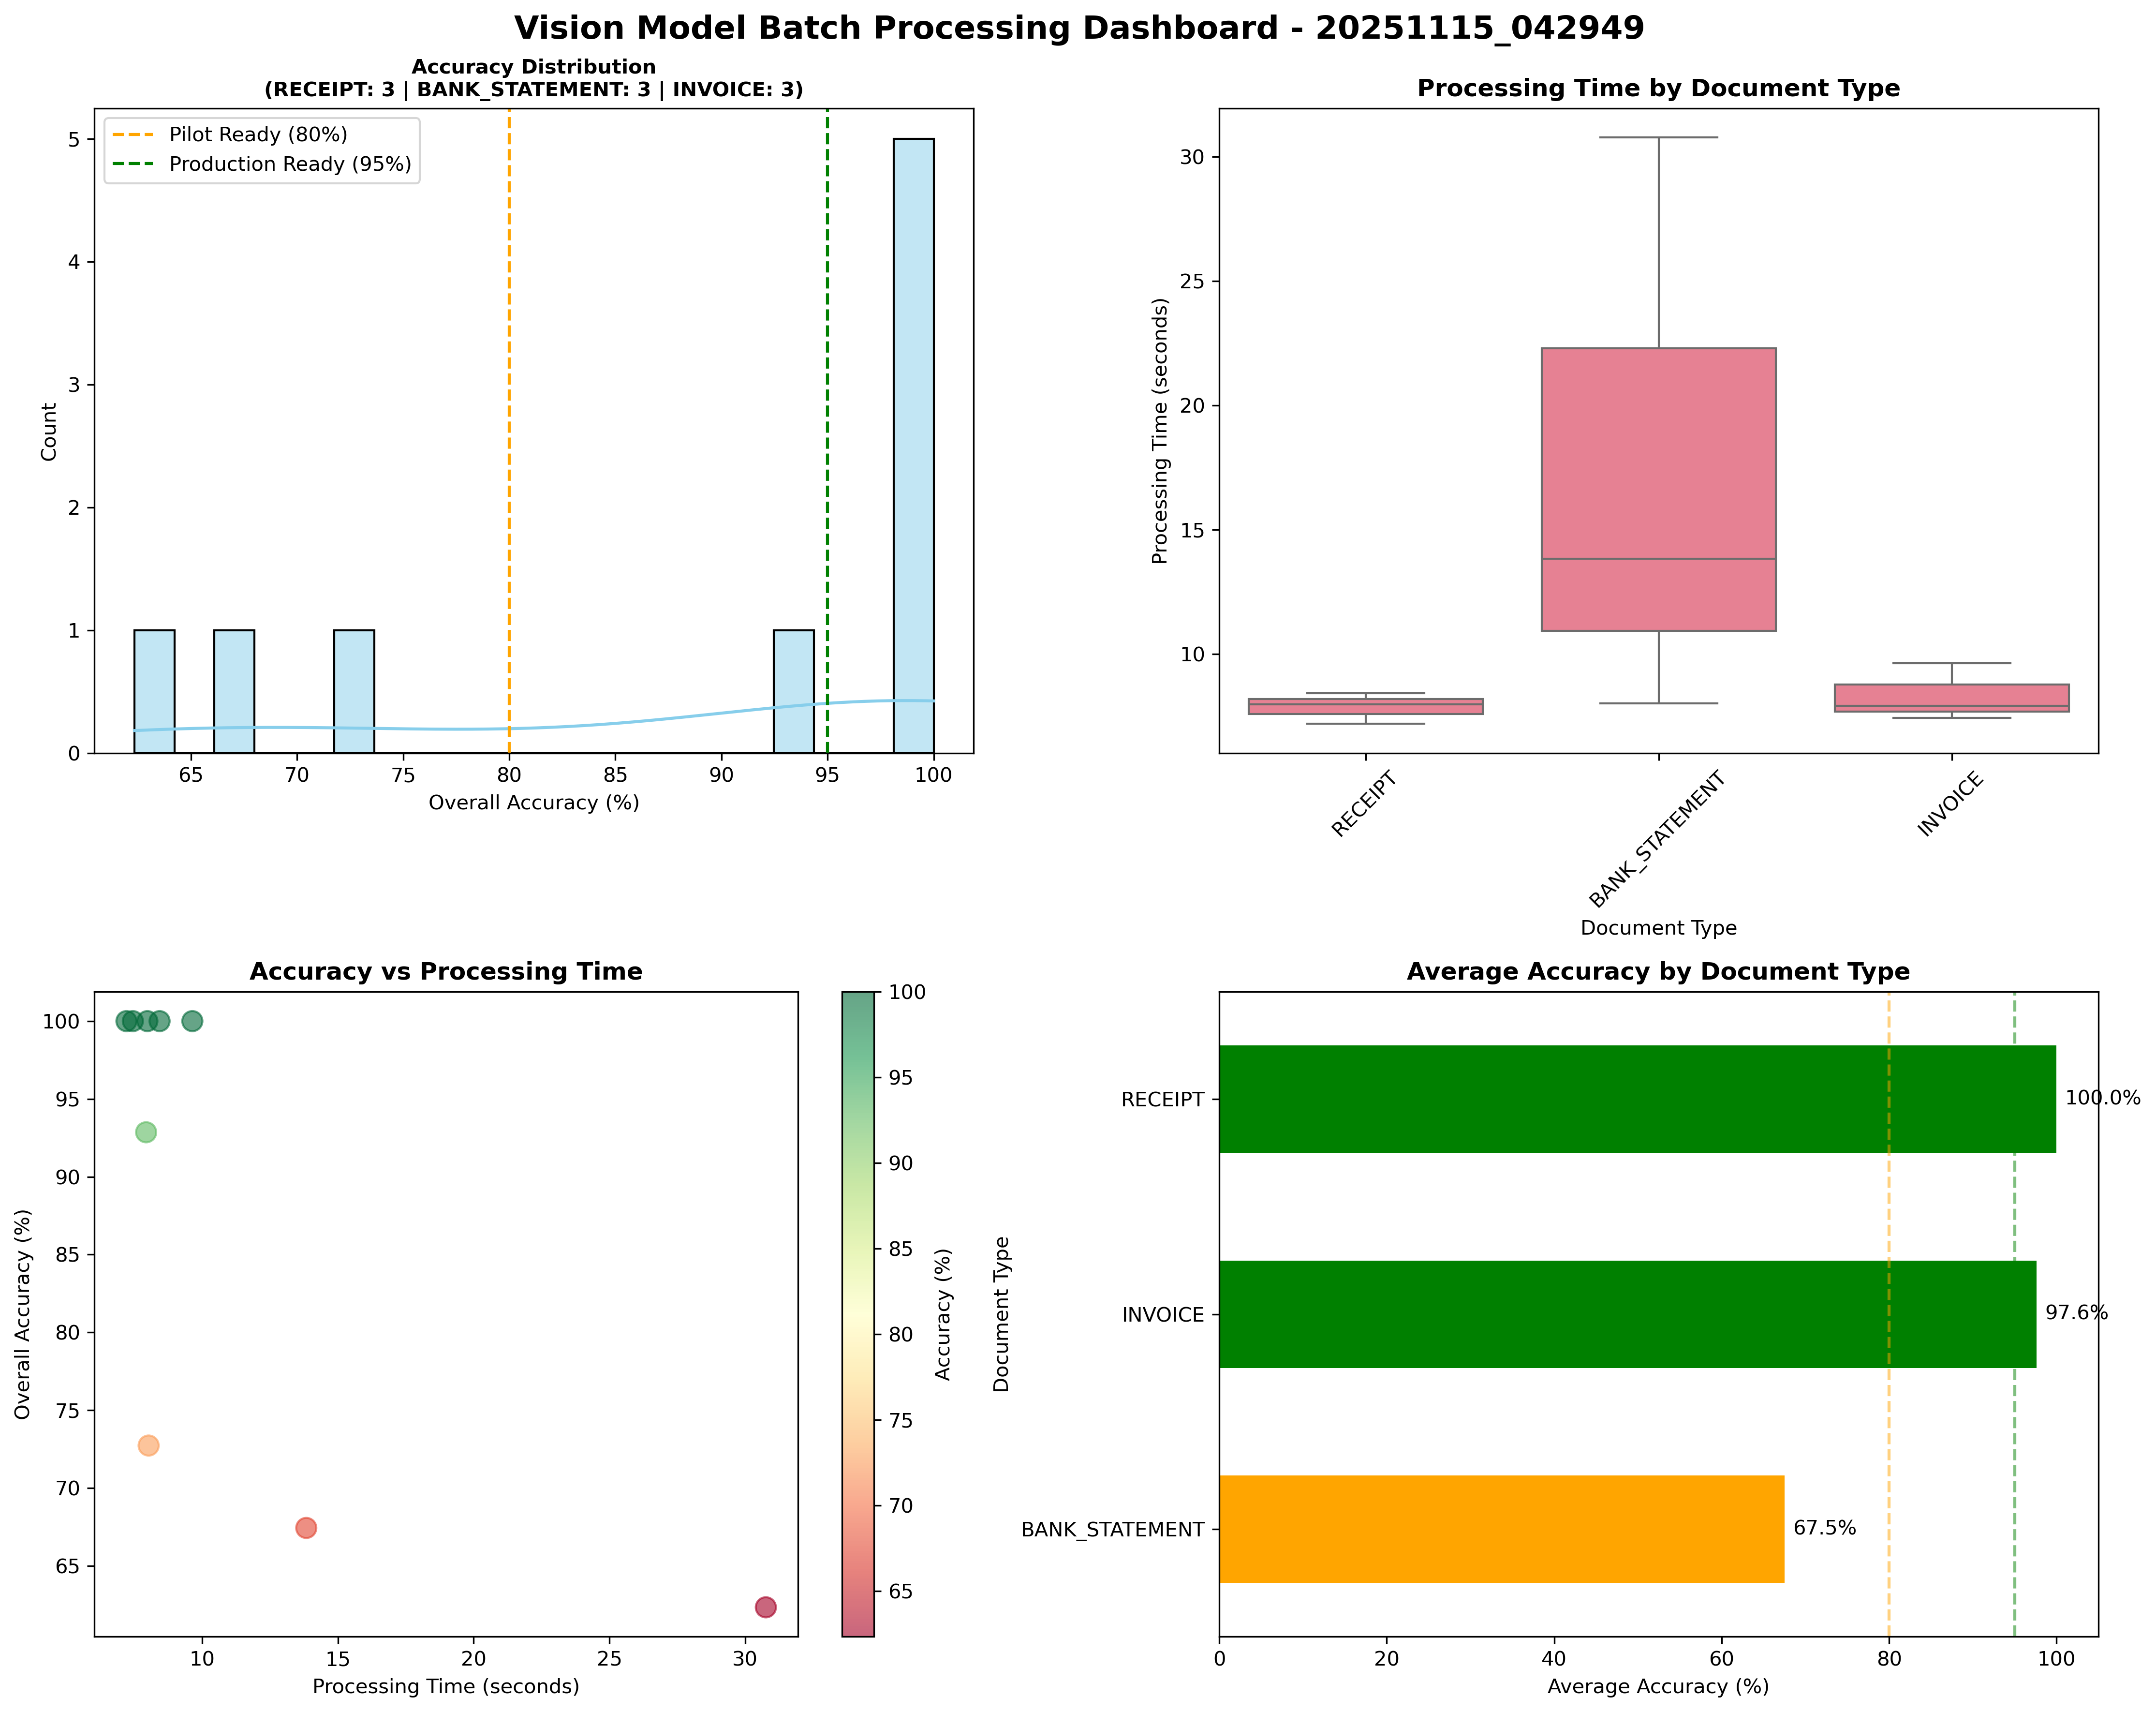

In [13]:
#Cell 11
# Display final summary
console.rule("[bold green]Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

In [14]:
#Cell 12
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!